## Analyzing MW articles

In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import string
from datetime import datetime
import re
import pickle
from functools import reduce
from collections import Counter
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from pytrends.request import TrendReq

%matplotlib inline

ModuleNotFoundError: No module named 'pytrends'

In [143]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('precision', 3)

In [144]:
with open('/Users/samfunk/ds/metis/project_luther/links.pkl', 'rb') as f:
    links = pickle.load(f)

df = pd.DataFrame()

dictlist = [x for x in links.items()]

df['article'] = [x[0].lower() for x in dictlist]
df['datetime'] = [x[1]['date'] for x in dictlist]
df['url'] = [x[1]['url'] for x in dictlist]

regex = re.compile('[%s]' % re.escape(string.punctuation.replace(':', '')))
df['datetime'] = df['datetime'].apply(lambda x: regex.sub('', x))

df['time'] = df['datetime'].apply(lambda x: re.search(r'^(.+?\s.+?)\s', x)[1])
df['time_string'] = df['time'].apply(lambda x: datetime.strptime(x, '%I:%M %p').time())

df['date'] = df['datetime'].apply(lambda x: re.search(r'([A-Z].*)', x)[1])
df['date'] = df['date'].apply(lambda x: re.sub(r'([A-Za-z]{3})[a-z]*', r'\1', x))
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%b %d %Y'))
df['date_string'] = df['date'].apply(lambda x: x.date())

#df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, '%b %d %Y %I:%M %p'))

df['datetime'] = df.apply(lambda x: datetime.combine(x['date_string'], x['time_string']), axis=1)

df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.weekday())

df['url'] = df['url'].apply(lambda x: 'http://marketwatch.com' + x if 'http' not in x else x)

df = df.sort_values('datetime')

#df = df['06-01-2017':]
df = df[(df['month'] > 5) & (df['month'] < 10)]
df = df[df['day'] < 5]

df_links = df.copy()

In [145]:
len(df)

10066

In [146]:
pickles = ['econ', 'fed', 'strong', 'soft']

for p in pickles:
    with open('/Users/samfunk/ds/metis/project_luther/' + p + '.pkl', 'rb') as f:
        globals()[str(p)] = pickle.load(f)

In [147]:
def to_df(dictfile, colname):
    
    df = pd.DataFrame()
    
    try:
        dictlist = [x for x in dictfile.items()]
    except:
        dictlist = dictfile

    df['article'] = [x[0].lower() for x in dictlist]
    df['datetime'] = [x[1]['date'] for x in dictlist]
    df['url'] = [x[1]['url'] for x in dictlist]
    df[colname] = 1
    
    regex = re.compile('[%s]' % re.escape(string.punctuation.replace(':', '')))
    df['datetime'] = df['datetime'].apply(lambda x: regex.sub('', x))

    df['time'] = df['datetime'].apply(lambda x: re.search(r'^(.+?\s.+?)\s', x)[1])
    df['time_string'] = df['time'].apply(lambda x: datetime.strptime(x, '%I:%M %p').time())

    df['date'] = df['datetime'].apply(lambda x: re.search(r'([A-Z].*)', x)[1])
    df['date'] = df['date'].apply(lambda x: re.sub(r'([A-Za-z]{3})[a-z]*', r'\1', x))
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%b %d %Y'))
    df['date_string'] = df['date'].apply(lambda x: x.date())

    #df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, '%b %d %Y %I:%M %p'))

    df['datetime'] = df.apply(lambda x: datetime.combine(x['date_string'], x['time_string']), axis=1)

    df['month'] = df['datetime'].apply(lambda x: x.month)
    df['day'] = df['datetime'].apply(lambda x: x.weekday())

    df['url'] = df['url'].apply(lambda x: 'http://marketwatch.com' + x if 'http' not in x else x)
    
    df = df.sort_values('datetime')
    
    #df = df['06-01-2017':]
    df = df[(df['month'] > 5) & (df['month'] < 10)]
    df = df[df['day'] < 5]

    return df.copy()
    

In [148]:
df_econ = to_df(econ, 'econ')
df_fed = to_df(fed, 'fed')
df_strong = to_df(strong, 'strong')
df_soft = to_df(soft, 'soft')
data = [df_links, df_econ, df_fed, df_strong, df_soft]

In [183]:
master = pd.concat(data, ignore_index=True)

In [184]:
c = Counter(master.datetime)
dups = [n for n in c if c[n] > 1]
mask = master.datetime.isin(dups)
result = master.loc[(~mask) | ((mask) & (master.econ > 0)) | ((mask) & (master.fed > 0)) | ((mask) & (master.strong > 0)) | ((mask) & (master.soft > 0)), :]

master = result.drop_duplicates()

In [185]:
master = master.fillna(0)
master = master[master['date'] != '2016-07-08']

In [197]:
count = master.groupby('date')['article'].count().reset_index().set_index('date')
sums = master.groupby('date')['econ', 'fed', 'strong', 'soft'].sum().reset_index().set_index('date')
master = sums.join(count, how='left')

In [201]:
master['econ_day'] = master['econ'] / master['article']
master['fed_day'] = master['fed'] / master['article']
master['strong_day'] = master['strong'] / master['article']
master['soft_day'] = master['soft'] / master['article']

master['fed_econ'] = master['fed'] / master['econ']

In [205]:
fed_strong_diff = master['fed'] - master['strong']
strong_soft = master['strong'] + master['soft']

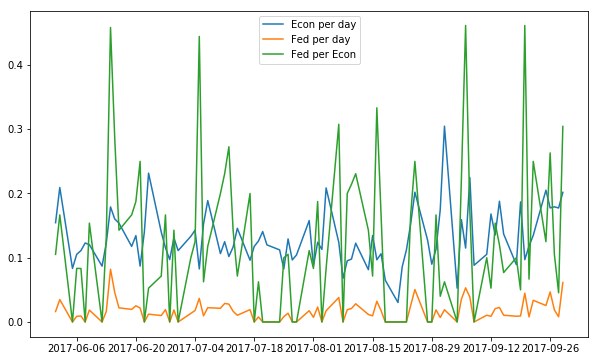

In [216]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(master.econ_day, label='Econ per day')
plt.plot(master.fed_day, label='Fed per day')
plt.plot(master.fed_econ, label='Fed per Econ')
plt.legend()

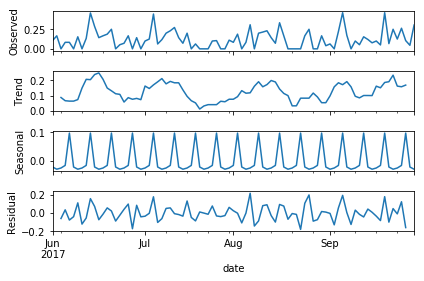

In [223]:
seasonal_decompose(master.fed_econ, model='additive').plot();

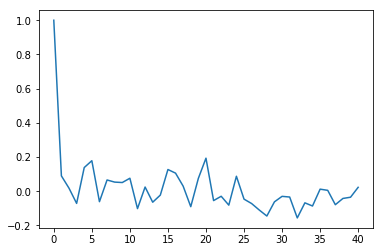

In [225]:
plt.plot(acf(master.))

In [171]:
master

,date,article,econ,fed,strong,soft,econ_day,fed_day,strong_day,soft_day,fed_econ
0,2017-06-01,1,19.0,2.0,3.0,4.0,19.0,2.0,3.0,4.0,0.105
1,2017-06-02,1,18.0,3.0,1.0,7.0,18.0,3.0,1.0,7.0,0.167
2,2017-06-05,1,9.0,0.0,0.0,1.0,9.0,0.0,0.0,1.0,0.000
3,2017-06-06,1,12.0,1.0,1.0,3.0,12.0,1.0,1.0,3.0,0.083
4,2017-06-07,1,12.0,1.0,1.0,5.0,12.0,1.0,1.0,5.0,0.083
5,2017-06-08,1,15.0,0.0,0.0,6.0,15.0,0.0,0.0,6.0,0.000
6,2017-06-09,1,13.0,2.0,2.0,7.0,13.0,2.0,2.0,7.0,0.154
7,2017-06-12,1,8.0,0.0,2.0,0.0,8.0,0.0,2.0,0.0,0.000
8,2017-06-13,1,15.0,2.0,3.0,4.0,15.0,2.0,3.0,4.0,0.133
9,2017-06-14,1,24.0,11.0,15.0,3.0,24.0,11.0,15.0,3.0,0.458


In [ ]:
def breadcrumbs(url):
    bread = []
    soup = BeautifulSoup(requests.get(url).text, 'html.parser')
    for crumb in soup.find_all(class_ = 'fa fa-angle-right breadcrumb_item'):
        bread.append(crumb.text.replace('\n', ''))
    return bread

#df['path'] = df['url'].apply(lambda x: breadcrumbs(x))